In [ ]:
# Run this cell to download required libraries for BioMedCliP.
!pip install open_clip_torch transformers matplotlib

In [2]:
# General Libraries.
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
import random
import torch
import glob
import json
import cv2
import os

# Libraries for BioMedCLiP.
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import HF_HUB_PREFIX, _MODEL_CONFIGS
from huggingface_hub import hf_hub_download

## Dataset Setup + Pre-processing

In [3]:
df = pd.read_csv('filtered_oasis_1.csv')
cdr_labels = {
    0.0: 'Non Demented',
    0.5: 'Very mild Dementia',
    1.0: 'Mild Dementia',
    2.0: 'Moderate Dementia',
    3.0: 'Severe Dementia'
}

df['CDR_Labels'] = df['CDR'].map(cdr_labels)
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,CDR_Labels
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,Non Demented
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,Non Demented
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,Very mild Dementia
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,NaN,Non Demented
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,NaN,Non Demented


In [4]:
# Download latest version of OASIS-1 images.
path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imagesoasis


In [5]:
BASE_PATH = '/kaggle/input/imagesoasis/Data/'
IMAGE_PATHS = glob.glob(f'{BASE_PATH}/**/*.jpg',recursive=True)
print("Number of raw images:", len(IMAGE_PATHS))

Number of raw images: 86437


In [6]:
MPR1_IMAGE_PATHS = [image_path for image_path in IMAGE_PATHS if '_mpr-1_' in image_path]
print("Sample paths:")
for idx in range(5):
    print(MPR1_IMAGE_PATHS[idx])

Sample paths:
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0114_MR1_mpr-1_130.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0375_MR1_mpr-1_136.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0159_MR1_mpr-1_131.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0198_MR1_mpr-1_137.jpg
/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0181_MR1_mpr-1_104.jpg


In [7]:
patient_data = df[['ID', 'CDR_Labels']].sort_values(by=['ID']).reset_index(drop=True)

patient_ids = patient_data['ID'].tolist()
cdr_labels_list = patient_data['CDR_Labels'].tolist()

for i in range(len(patient_ids)):
    print(f"Patient ID: {patient_ids[i]}, CDR Label: {cdr_labels_list[i]}")

Patient ID: OAS1_0001_MR1, CDR Label: Non Demented
Patient ID: OAS1_0002_MR1, CDR Label: Non Demented
Patient ID: OAS1_0003_MR1, CDR Label: Very mild Dementia
Patient ID: OAS1_0004_MR1, CDR Label: Non Demented
Patient ID: OAS1_0005_MR1, CDR Label: Non Demented
Patient ID: OAS1_0006_MR1, CDR Label: Non Demented
Patient ID: OAS1_0007_MR1, CDR Label: Non Demented
Patient ID: OAS1_0009_MR1, CDR Label: Non Demented
Patient ID: OAS1_0010_MR1, CDR Label: Non Demented
Patient ID: OAS1_0011_MR1, CDR Label: Non Demented
Patient ID: OAS1_0012_MR1, CDR Label: Non Demented
Patient ID: OAS1_0013_MR1, CDR Label: Non Demented
Patient ID: OAS1_0014_MR1, CDR Label: Non Demented
Patient ID: OAS1_0015_MR1, CDR Label: Very mild Dementia
Patient ID: OAS1_0016_MR1, CDR Label: Very mild Dementia
Patient ID: OAS1_0017_MR1, CDR Label: Non Demented
Patient ID: OAS1_0018_MR1, CDR Label: Non Demented
Patient ID: OAS1_0019_MR1, CDR Label: Non Demented
Patient ID: OAS1_0020_MR1, CDR Label: Non Demented
Patient ID: O

In [8]:
# Pick the middle slice for any patient's images.
def select_images(patient_id, select_one=False):
    img_list = [image_path for image_path in MPR1_IMAGE_PATHS if f"_{patient_id}_" in image_path]
    img_list.sort()
    if (select_one):
        if img_list:
            return [img_list[len(img_list) // 2]]
        else:
            return []
    else:
        return img_list

random_id = random.choice(patient_ids).split('_')[1]
print(f"Selected random ID: {random_id}")
selected_images = select_images(random_id, select_one=True)

selected_images

Selected random ID: 0344


['/kaggle/input/imagesoasis/Data/Non Demented/OAS1_0344_MR1_mpr-1_130.jpg']

## Image Captioning

In [9]:
# Define the context for the scores
score_context = {
    'MMSE': "MMSE (Mini-Mental State Examination) is a cognitive assessment used to evaluate cognitive function. A score of 24-30 indicates normal cognitive function, while scores below 24 suggest cognitive impairment.",
    'eTIV': "eTIV (estimated Total Intracranial Volume) measures the volume of the skull, which is related to brain size. The normal range varies based on age and sex, but it's generally around 1400-1600 cm^3.",
    'nWBV': "nWBV (normalized Whole Brain Volume) is the proportion of the brain's volume relative to the total intracranial volume. A higher percentage generally suggests better brain health, with a range from ~70% to 85%.",
    'ASF': "ASF (Atlas Scaling Factor) adjusts the image to match a reference template. Values around 1 indicate good alignment, while values significantly higher or lower may indicate problems with the scaling or registration process."#,
}

# Function to handle missing or unavailable values
def handle_missing_value(value, column_name):
    if pd.isna(value) or value == -1:
        return "Information unavailable."
    return str(value)

# Function to generate the caption for each image
def generate_caption(row):
    caption = (
        f"Patient ID: {row['ID']},\n"
        f"Gender: {row['M/F']}, Handedness: {row['Hand']}, Age: {row['Age']} years,\n"
        f"Education: {handle_missing_value(row['Educ'], 'Education')},\n"
        f"Socioeconomic Status: {handle_missing_value(row['SES'], 'Socioeconomic Status')},\n"
        f"MMSE: {handle_missing_value(row['MMSE'], 'MMSE')} ({score_context.get('MMSE', '')}),\n"
        f"eTIV: {handle_missing_value(row['eTIV'], 'eTIV')} ({score_context.get('eTIV', '')}),\n"
        f"nWBV: {handle_missing_value(row['nWBV'], 'nWBV')} ({score_context.get('nWBV', '')}),\n"
        f"ASF: {handle_missing_value(row['ASF'], 'ASF')} ({score_context.get('ASF', '')})."
    )

    return caption


captions = []
for i in range(len(patient_ids)):
  current_id = patient_ids[i].split('_')[1]
  current_label = cdr_labels_list[i]

  selected_images = select_images(current_id, select_one=True)

  # Generate captions for each image in the selected images list
  for image_path in selected_images:
    if (len(selected_images) != 0):
      patient_id = image_path.split('/')[-1].split('_')[0] + '_' + image_path.split('\\')[-1].split('_')[1]+"_MR1"
      patient_data = df[df['ID'] == patient_id]
      if patient_data.empty:
          print(f"Warning: No data found for patient ID {patient_id}. Skipping image {image_path}.")
          continue
      patient_data = patient_data.iloc[0]
      caption = generate_caption(patient_data)
      captions.append(caption)
      df.loc[df['ID'] == patient_id, 'CustomCaption'] = caption

# Display a caption for a random image
random_idx = random.choice(range(len(captions)))
print(f"Caption for image {patient_ids[random_idx]}:\n\n{captions[random_idx]}")


Caption for image OAS1_0204_MR1:

Patient ID: OAS1_0205_MR1,
Gender: M, Handedness: R, Age: 75 years,
Education: 4.0,
Socioeconomic Status: 1.0,
MMSE: 30.0 (MMSE (Mini-Mental State Examination) is a cognitive assessment used to evaluate cognitive function. A score of 24-30 indicates normal cognitive function, while scores below 24 suggest cognitive impairment.),
eTIV: 1891 (eTIV (estimated Total Intracranial Volume) measures the volume of the skull, which is related to brain size. The normal range varies based on age and sex, but it's generally around 1400-1600 cm^3.),
nWBV: 0.716 (nWBV (normalized Whole Brain Volume) is the proportion of the brain's volume relative to the total intracranial volume. A higher percentage generally suggests better brain health, with a range from ~70% to 85%.),
ASF: 0.928 (ASF (Atlas Scaling Factor) adjusts the image to match a reference template. Values around 1 indicate good alignment, while values significantly higher or lower may indicate problems with

In [10]:
df.head(347)

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,CDR_Labels,CustomCaption
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,Non Demented,"Patient ID: OAS1_0001_MR1,\nGender: F, Handedn..."
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,Non Demented,"Patient ID: OAS1_0002_MR1,\nGender: F, Handedn..."
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,Very mild Dementia,"Patient ID: OAS1_0003_MR1,\nGender: F, Handedn..."
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,NaN,Non Demented,"Patient ID: OAS1_0004_MR1,\nGender: M, Handedn..."
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,NaN,Non Demented,"Patient ID: OAS1_0005_MR1,\nGender: M, Handedn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,OAS1_0378_MR1,F,R,58,2.0,2.0,30.0,0.0,1418,0.821,1.238,NaN,Non Demented,"Patient ID: OAS1_0378_MR1,\nGender: F, Handedn..."
343,OAS1_0379_MR1,F,R,20,NaN,NaN,NaN,0.0,1255,0.866,1.398,NaN,Non Demented,"Patient ID: OAS1_0379_MR1,\nGender: F, Handedn..."
344,OAS1_0380_MR1,F,R,83,1.0,5.0,18.0,0.5,1313,0.705,1.337,NaN,Very mild Dementia,"Patient ID: OAS1_0380_MR1,\nGender: F, Handedn..."
345,OAS1_0381_MR1,M,R,59,4.0,2.0,29.0,0.0,1795,0.809,0.978,NaN,Non Demented,"Patient ID: OAS1_0381_MR1,\nGender: M, Handedn..."


## BioMedCLiP Setup

In [11]:
# Download the model and config files.
hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin",
    local_dir="checkpoints"
)

hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_config.json",
    local_dir="checkpoints"
)

# Load the BiomedCLiP model and tokenizer.
model_name = "biomedclip_local"

with open("checkpoints/open_clip_config.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]

if (not model_name.startswith(HF_HUB_PREFIX)
        and model_name not in _MODEL_CONFIGS
        and config is not None):
    _MODEL_CONFIGS[model_name] = model_cfg

# Load model, tokenizer, and preprocessing function.
model, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="checkpoints/open_clip_pytorch_model.bin",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)

tokenizer = get_tokenizer(model_name)

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

## Evaluation (Forward Pass)

In [26]:
def process_image(image_path, preprocess, device, show = False, title=None):
    original = Image.open(image_path)
    image = cv2.cvtColor(np.array(original), cv2.COLOR_RGB2BGR)
    # Resize to 224x224 for CLiP
    image = cv2.resize(image, (224, 224))
    rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    processed = Image.fromarray(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    image_input = preprocess(processed).unsqueeze(0).to(device)


    if show:
        image_to_show = T.ToPILImage()(image_input.squeeze(0).cpu())
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(original)
        axs[0].set_title("Original")
        axs[0].axis('off')

        axs[1].imshow(processed)
        axs[1].set_title("Pre-Processed")
        axs[1].axis('off')

        axs[2].imshow(image_to_show)
        axs[2].set_title("After Preprocessing for CLiP (Normalized)")
        axs[2].axis('off')

        if title:
            plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()
        return

    return image_input

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")



def classify_all_patients(df, image_paths, prompt = '\nThis is a photo of'):
    predictions = []

    model.to(device)
    model.eval()

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        patient_id = row['ID']
        dementia_stage = row['CDR_Labels']

        stage_folder = dementia_stage
        patient_images = [image for image in image_paths if f"{patient_id}_mpr-1_130" in image and stage_folder in image]
        if not patient_images:
            print(f"Warning: No image found for patient {patient_id} in stage {dementia_stage}. Skipping classification.")
            continue

        image_path = patient_images[0]
        middle_image_list = image_path

        if not middle_image_list:
            print(f"Warning: No image path returned for patient {patient_id}, skipping classification.")
            continue

        image_input = process_image(middle_image_list, preprocess, device)

        context_length = 256

        images = torch.stack([image_input]).to(device)
        template = str(row['CustomCaption']) + 
        

        # Binary Prediction Loop.
        labels = [
            'No Alzheimer\'s',
            'Alzheimer\'s'
        ]

        texts = tokenizer([template + ' ' + l for l in labels], context_length=context_length).to(device)
        with torch.no_grad():
          image_features, text_features, logit_scale = model(image_input, texts)

          logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1)
          sorted_indices = torch.argsort(logits, dim=-1, descending=True)

          logits = logits.cpu().numpy()
          sorted_indices = sorted_indices.cpu().numpy()
          pred_binary = labels[sorted_indices[0][0]]


        # Multiclass Prediction.
        labels = [
            'Non Demented',
            'Very mild Dementia',
            'Mild Dementia',
            'Moderate Dementia',
            'Severe Dementia'
        ]

        texts = tokenizer([template +  ' ' + l for l in labels], context_length=context_length).to(device)
        with torch.no_grad():
          image_features, text_features, logit_scale = model(image_input, texts)

          logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1)
          sorted_indices = torch.argsort(logits, dim=-1, descending=True)

          logits = logits.cpu().numpy()
          sorted_indices = sorted_indices.cpu().numpy()


          pred = labels[sorted_indices[0][0]]


        predictions.append({
            'Patient_ID': patient_id,
            'Prediction_Multiclass': pred,
            'Prediction_binary': pred_binary,
            'True Label': row['CDR_Labels'],
        })

    return pd.DataFrame(predictions)


# Classify Alzheimer's for all patients using the image paths
predictions_df = classify_all_patients(df, IMAGE_PATHS)

Using device: cuda


## Data Visualization

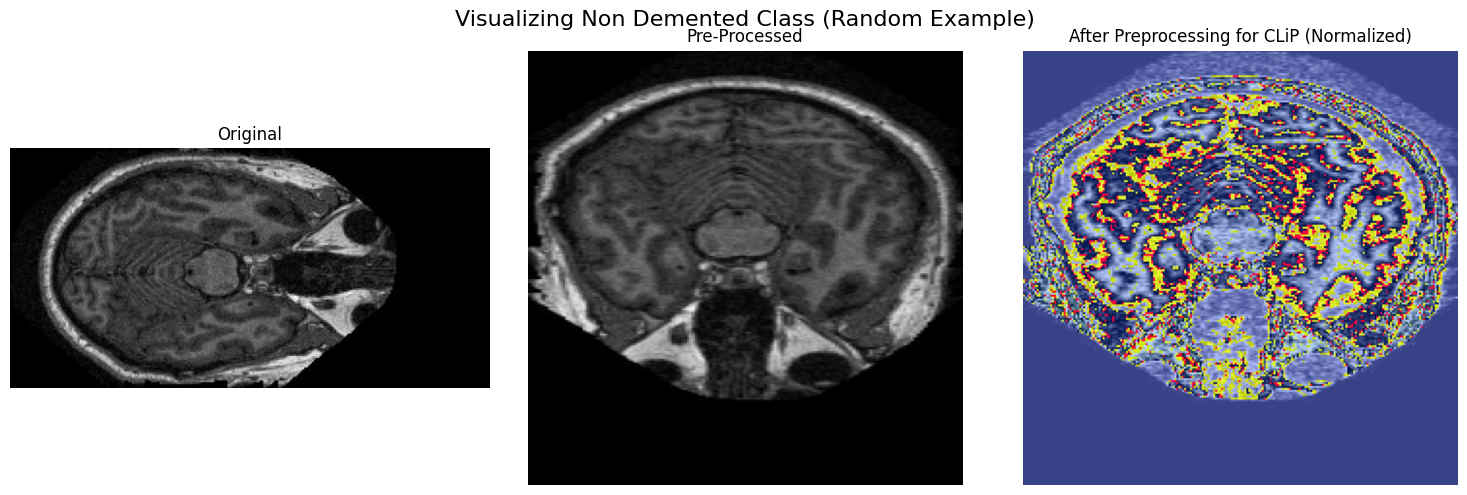

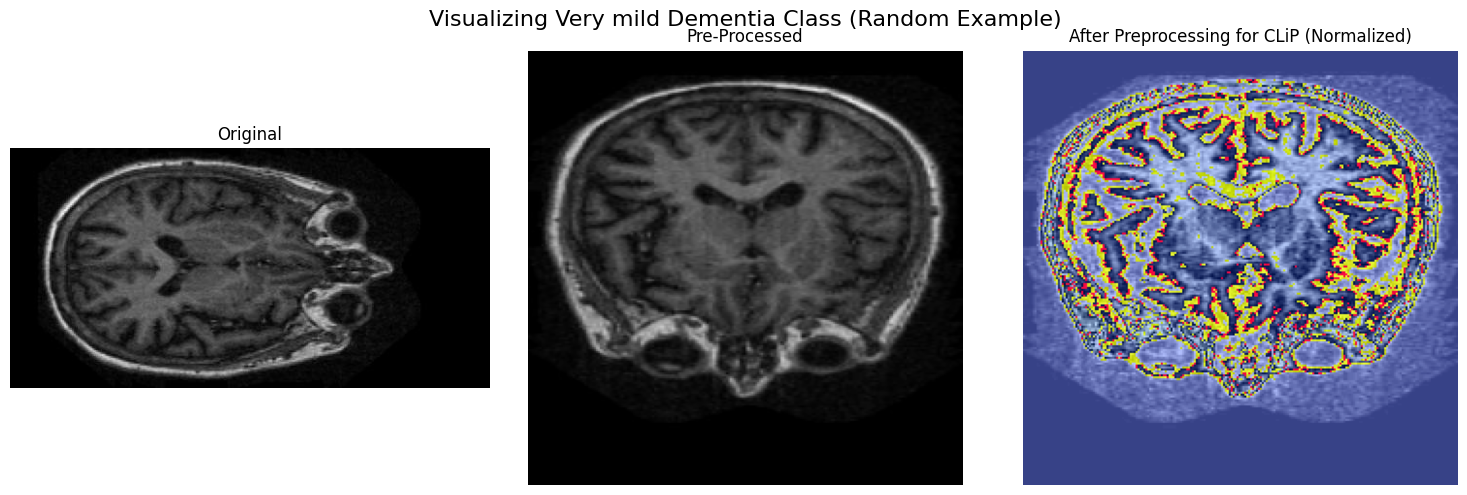

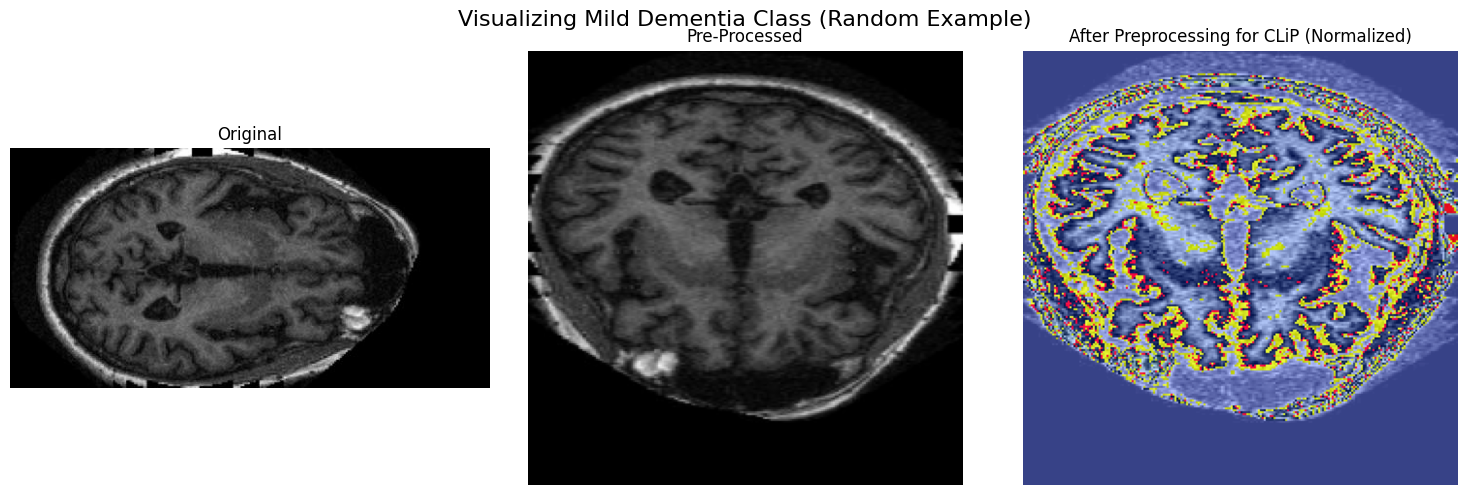

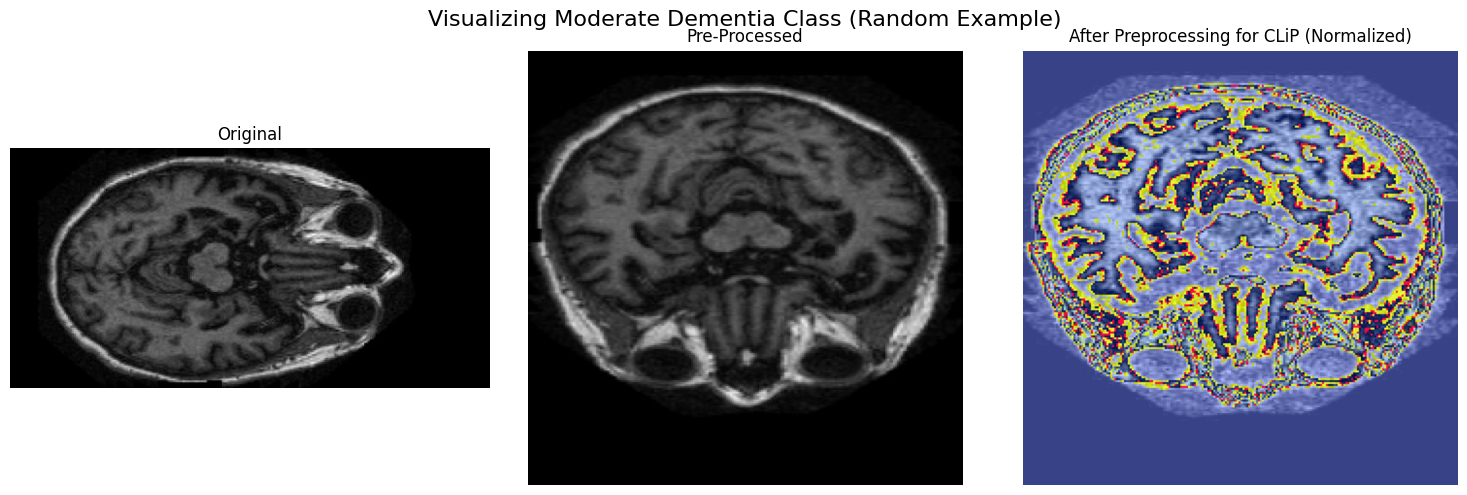

In [29]:
dementia_labels = df['CDR_Labels'].unique()

np.random.seed(42)

for label in dementia_labels:

    patient_ids = df[df['CDR_Labels'] == label]['ID'].unique()
    if len(patient_ids) == 0:
        print(f"No patients found for label: {label}")
        continue

    selected_patient_id = np.random.choice(patient_ids)[5:-4]

    image_paths = select_images(selected_patient_id, BASE_PATH)
    if not image_paths:
        print(f"No image found for patient ID: {selected_patient_id}")
        continue

    original_image = Image.open(image_paths[0])
    process_image(image_paths[0], preprocess, device, show=True, title= f"Visualizing {label} Class (Random Example)")

    plt.show()

In [30]:
# Check results for a few examples.
predictions_df.head(10)

,Patient_ID,Prediction_Multiclass,Prediction_binary,True Label
0,OAS1_0001_MR1,Very mild Dementia,Alzheimer's,Non Demented
1,OAS1_0002_MR1,Very mild Dementia,No Alzheimer's,Non Demented
2,OAS1_0003_MR1,Very mild Dementia,No Alzheimer's,Very mild Dementia
3,OAS1_0004_MR1,Very mild Dementia,No Alzheimer's,Non Demented
4,OAS1_0005_MR1,Non Demented,No Alzheimer's,Non Demented
5,OAS1_0006_MR1,Severe Dementia,Alzheimer's,Non Demented
6,OAS1_0007_MR1,Non Demented,No Alzheimer's,Non Demented
7,OAS1_0009_MR1,Very mild Dementia,Alzheimer's,Non Demented
8,OAS1_0010_MR1,Very mild Dementia,Alzheimer's,Non Demented
9,OAS1_0011_MR1,Moderate Dementia,No Alzheimer's,Non Demented


## Results

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_binary_predictions(df, predictions_df):
    merged_df = pd.merge(df, predictions_df, left_on='ID', right_on='Patient_ID', how='inner')
    merged_df['CDR_Binary'] = np.where(merged_df['CDR_Labels'] == 'Non Demented', "No Alzheimer's", "Alzheimer's")

    y_true = merged_df['CDR_Binary']
    y_pred = merged_df['Prediction_binary']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label="Alzheimer's")
    recall = recall_score(y_true, y_pred, pos_label="Alzheimer's")
    f1 = f1_score(y_true, y_pred, pos_label="Alzheimer's")
    cm = confusion_matrix(y_true, y_pred, labels=["No Alzheimer's", "Alzheimer's"])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Alzheimer's", "Alzheimer's"],
                yticklabels=["No Alzheimer's", "Alzheimer's"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for Binary Classification")
    plt.tight_layout()
    plt.show()

def evaluate_predictions(df, predictions_df, cdr_labels):
    merged_df = pd.merge(df, predictions_df, left_on='ID', right_on='Patient_ID', how='inner')

    true_labels = merged_df['CDR_Labels']
    predicted_labels = merged_df['Prediction_Multiclass']

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=cdr_labels.values(), yticklabels=cdr_labels.values())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix for Multi-class Classification")
    plt.tight_layout()
    plt.show()

Accuracy: 0.6000
Precision: 0.1505
Recall: 0.1728
F1 Score: 0.1609


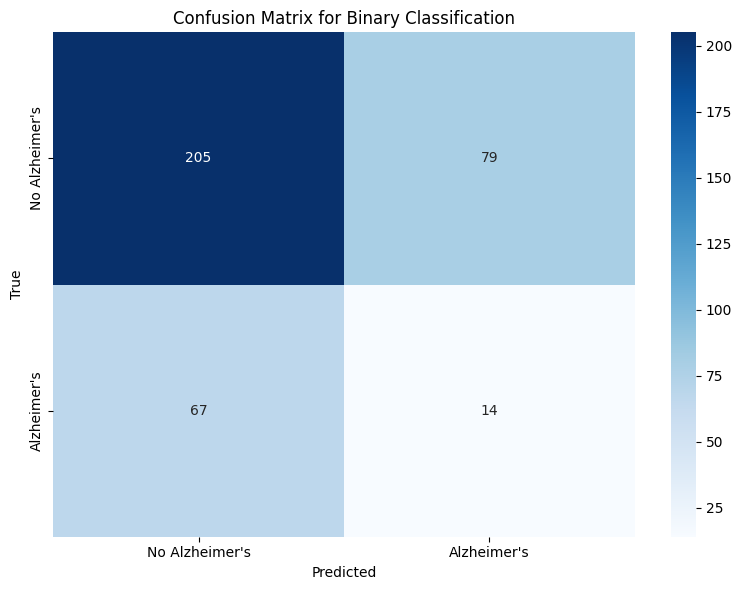

In [32]:
evaluate_binary_predictions(df, predictions_df)

Accuracy: 0.2219
Precision: 0.1721
Recall: 0.1531
F1 Score: 0.1065


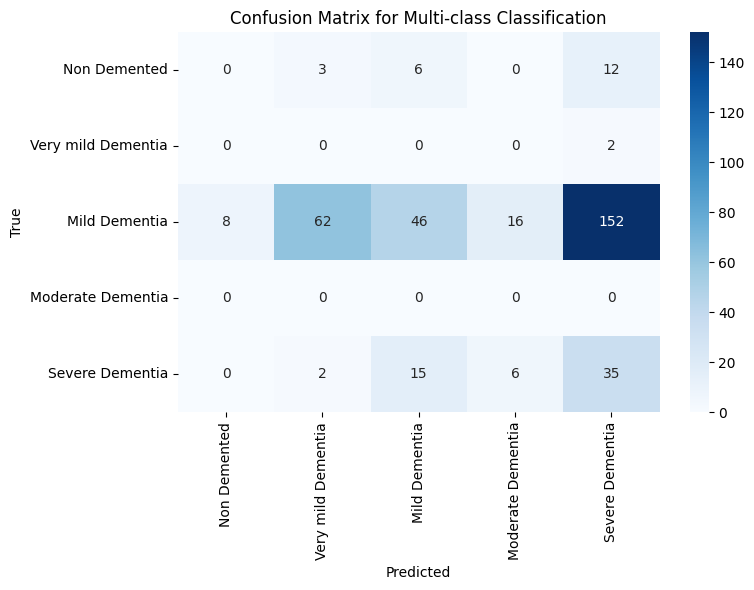

In [33]:
evaluate_predictions(df, predictions_df, cdr_labels)

## Prompt Analysis

Results for prompt: A medical expert looking to assess for a neuro-degenerative disease would likely classify this as 

Accuracy: 0.2384
Precision: 0.2256
Recall: 1.0000
F1 Score: 0.3682


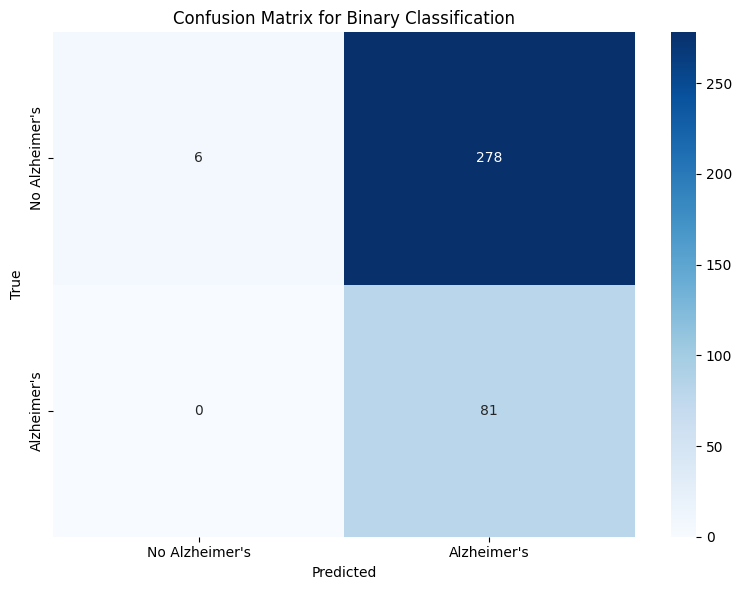

Accuracy: 0.1589
Precision: 0.0397
Recall: 0.2500
F1 Score: 0.0686


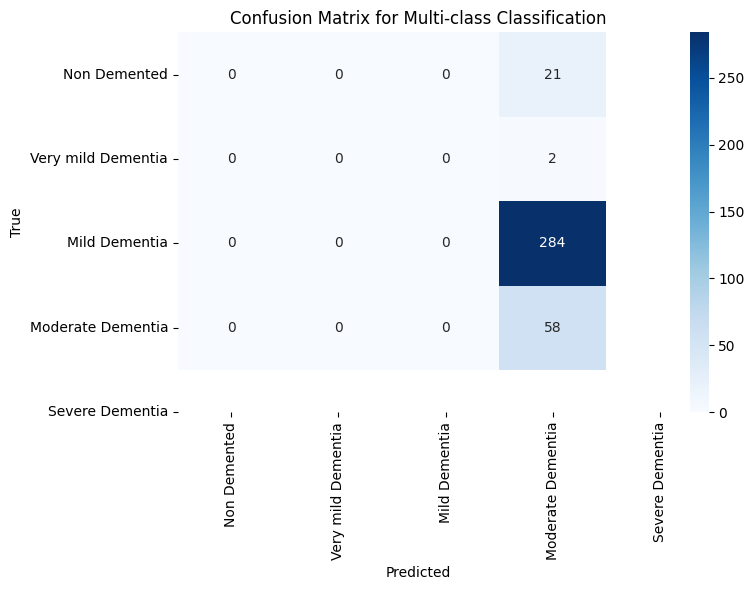

In [ ]:
prompt1 = 'A medical expert looking to assess for a neuro-degenerative disease would likely classify this as '
prompt1_pred_df = classify_all_patients(df, IMAGE_PATHS, prompt=prompt1)

print(f"Results for prompt: {prompt1}\n")
evaluate_binary_predictions(df, prompt1_pred_df)
evaluate_predictions(df, prompt1_pred_df, cdr_labels)

Results for prompt: The brain MRI scan of this patient is likely to be classified as 

Accuracy: 0.3096
Precision: 0.2121
Recall: 0.7778
F1 Score: 0.3333


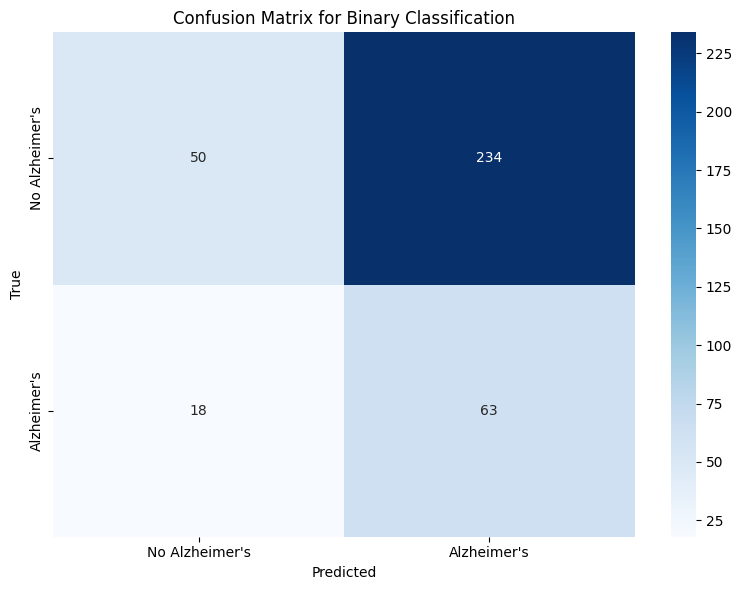

Accuracy: 0.1452
Precision: 0.2542
Recall: 0.2532
F1 Score: 0.1062


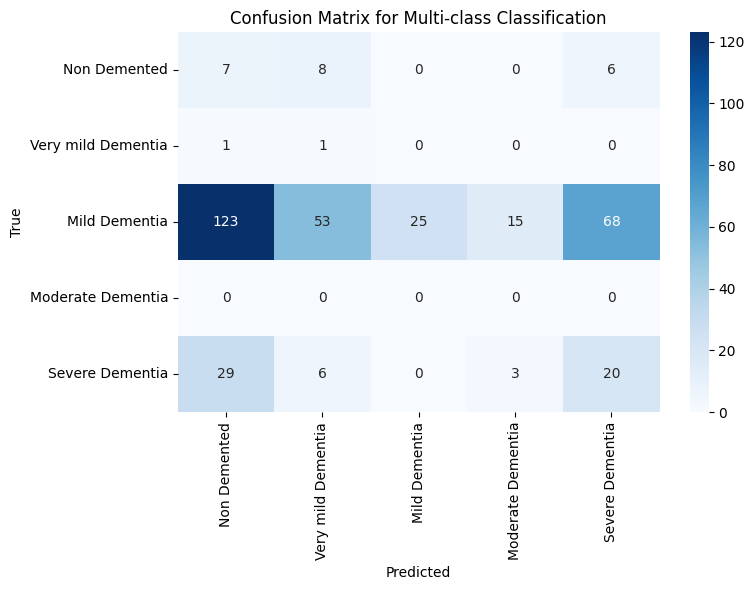

In [ ]:
prompt2 = 'The brain MRI scan of this patient is likely to be classified as '
prompt2_pred_df = classify_all_patients(df, IMAGE_PATHS, prompt=prompt2)

print(f"Results for prompt: {prompt2}\n")
evaluate_binary_predictions(df, prompt2_pred_df)
evaluate_predictions(df, prompt2_pred_df, cdr_labels)

Results for prompt: Based on the brain scan and given indicators, the patient most likely has the following diagnosis or stage of Alzheimer's disease: 

Accuracy: 0.2301
Precision: 0.2238
Recall: 1.0000
F1 Score: 0.3657


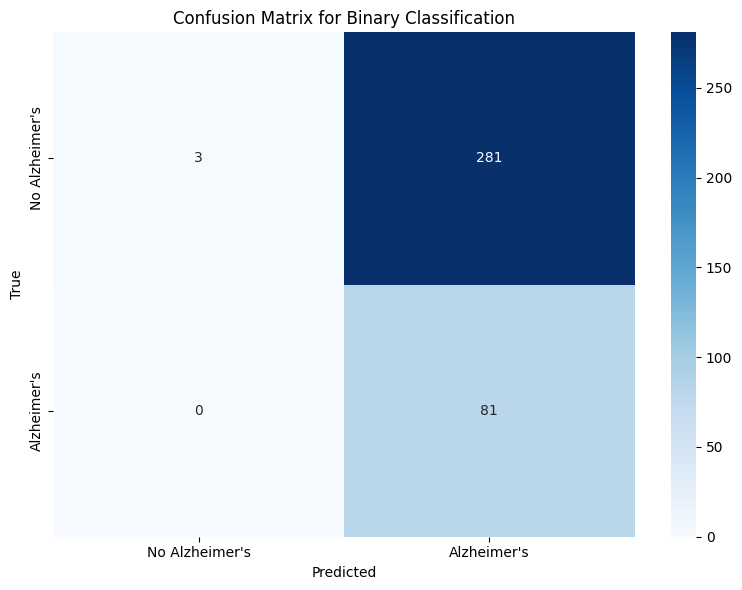

Accuracy: 0.2110
Precision: 0.2919
Recall: 0.2667
F1 Score: 0.1031


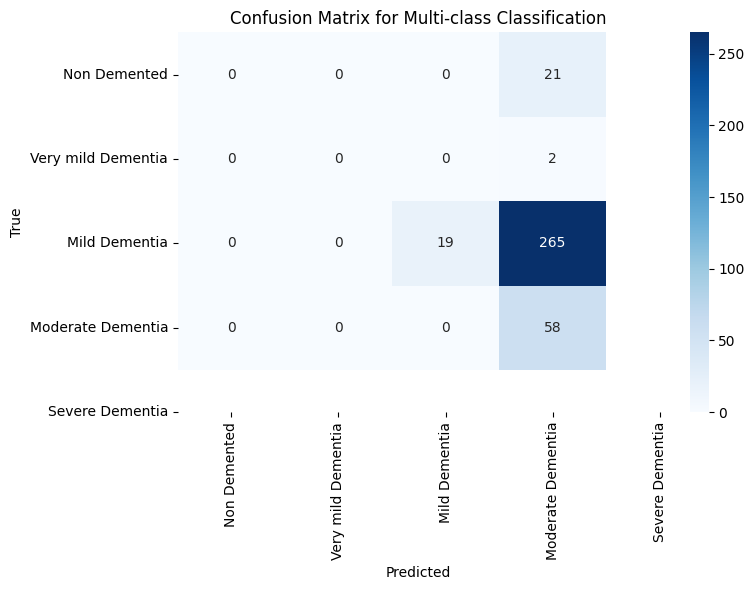

In [ ]:
prompt3 = 'Based on the brain scan and given indicators, the patient most likely has the following diagnosis or stage of Alzheimer\'s disease: '
prompt3_pred_df = classify_all_patients(df, IMAGE_PATHS, prompt=prompt3)

print(f"Results for prompt: {prompt3}\n")
evaluate_binary_predictions(df, prompt3_pred_df)
evaluate_predictions(df, prompt3_pred_df, cdr_labels)

## Takeaways:

- The nature of the final prompt that is added to the captions highly affect the result of the model. An improvement could be to learn better prompts for the VLM e.g. through BiomedCoOp, a tool to achieve effective prompt content. (Link to Paper: https://arxiv.org/html/2411.15232v2)
- The added indicators in the custom captions play a huge role in increasing the performance of the model for zero-shot classification.
- Model itself is not highly capable of zero-shot classification, further improvements require either full finetuning of the model based on training data (similar to what we provided) or through LoRA (different modules, one for binary classification with an addition of another module pertaining to different stages of Alzheimer's).Reference to GitHub: https://github.com/LightersWang/BiomedCLIP-LoRA

